In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import math

np.random.seed(1010121)


In [2]:
eps = 1e-9


In [3]:
def rand_indexes(n, m):
    return np.random.choice(n, m, replace=False)


def gen_f(n, k):
    m = np.random.rand(n, n) * 2
    Q, _ = np.linalg.qr(m)
    D = np.diag(np.array([k] + [1] * (n - 1)))

    result = Q @ D @ np.linalg.inv(Q)

    def f_impl(x):
        return x.T @ result @ x

    def f(x):
        return np.apply_along_axis(f_impl, 0, x)

    return f


def batch_gradient(f, x, m):
    n = len(x)
    indexes = rand_indexes(n, m)
    h = np.array([[0.0] * n for i in range(n)])
    for i in indexes:
        h[i][i] = 1e-6

    l = f(x[:, np.newaxis] + h)
    r = f(x[:, np.newaxis] - h)

    return (l - r) / (2*(1e-6))


def gradient_descent(f, x, lr, batch_size, lim=500, eps_mode=False):
    n = len(x)
    points = []
    points.append(x)
    if eps_mode:
        while not abs(f(x) - f(x - lr * (g := batch_gradient(f, x, batch_size)))) < eps:
            x = x - lr * g
            points.append(x)

            if len(points) > lim:
                return np.array(points)
    else:
        for _ in range(lim):
            x = x - lr * (g := batch_gradient(f, x, batch_size))
            points.append(x)

    return np.array(points)


def gradient_descent_count(f, x, lr, batch_size, lim=500, eps_mode=False):
    n = len(x)
    points = 1
    if eps_mode:
        while not abs(f(x) - f(x - lr * (g := batch_gradient(f, x, batch_size)))) < eps:
            x = x - lr * g
            points += 1

            if points > lim:
                return points
    else:
        for _ in range(lim):
            # while not abs(f(x) - f(x - lr * (g := batch_gradient(f,x, batch_size)))) < eps:
            # print(f(x) - f(x - lr * (g := batch_gradient(f,x, batch_size))))
            x = x - lr * (g := batch_gradient(f, x, batch_size))
            points += 1

    return points


# Task 1

### Example usage

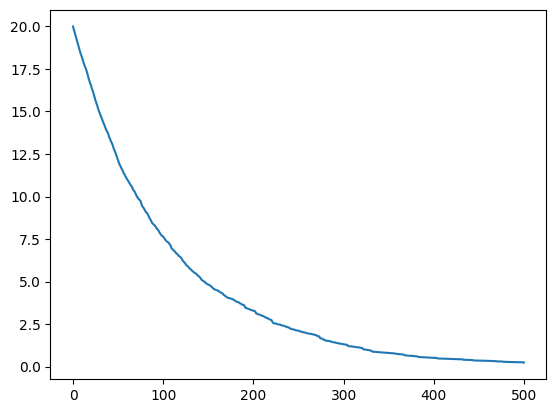

In [4]:
n = 20
k = 1
lr = 0.05
f = gen_f(n, k)
x = np.array([-1.0] * n)

points = gradient_descent(f, x, lr, 1, eps_mode=True)

plt.plot(list(map(f, points)))
plt.show()


### Batch size comparison: illustration

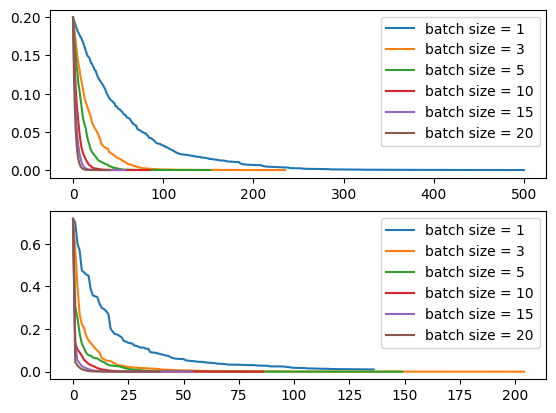

In [5]:
def test(k, ax):
    n = 20
    lr = 0.1
    x = np.array([-0.1] * n)
    f = gen_f(n, k)

    sizes = [1, 3, 5, 10, 15, 20]

    for bs in sizes:
        points = gradient_descent(f, x, lr, bs, eps_mode=True)

        ax.plot(list(map(f, points)))

    ax.legend(
        list(map(lambda bs: f'batch size = {bs}', [1, 3, 5, 10, 15, 20])))


fig, axs = plt.subplots(2, 1)


test(1, axs[0])
test(5, axs[1])


### Batch size comparison: measurement

In [6]:
n = 20
sizes = list(range(1, 21))
iters = 40
results = {}
for _ in range(iters):
    x = np.random.rand(n)
    f = gen_f(n, 1 + np.random.rand())
    for bs in sizes:
        points = gradient_descent_count(f, x, lr, bs, eps_mode=True)
        if not bs in results:
            results[bs] = 0
        results[bs] += points / iters

display(pd.DataFrame([results.values()],
        columns=results.keys(), index=['avg iteration count']))


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
avg iteration count,479.125,500.7,491.05,401.1,337.625,290.75,256.575,230.175,205.1,186.15,171.75,158.8,147.675,137.85,129.1,120.875,113.55,108.1,102.275,96.85


# Task 2
### Learning rate scheduling functions

In [7]:
def gen_const_lr(c):
    return lambda: c


def gen_timed_lr(lr0, d):
    lr = [lr0]
    n = [1]

    def f():
        result = lr[0]
        lr[0] = lr[0] / (1 + d * n[0])
        n[0] += 1
        return result

    return f


def gen_stepped_lr(lr0, d, r):
    n = [0]

    def f():
        n_ = n[0]
        n[0] += 1
        return lr0 * d ** (np.floor(1 + n_ / r))

    return f


def gen_exponential_lr(lr0, d):
    n = [1]

    def f():
        n_ = n[0]
        n[0] += 1
        return lr0 * math.e ** (-d * n_)

    return f


def lrf_gradient_descent(f, x, lrf, batch_size, lim=1000, eps_mode=False):
    n = len(x)
    points = []
    points.append(x)
    lr = lrf()
    if eps_mode:
        while not abs(f(x) - f(x - lr * (g := batch_gradient(f, x, batch_size)))) < eps:
            x = x - lr * g
            points.append(x)
            lr = lrf()

            if len(points) > lim:
                return np.array(points)
    else:
        for _ in range(lim):
            # while not abs(f(x) - f(x - lr * (g := batch_gradient(f,x, batch_size)))) < eps:
            # print(f(x) - f(x - lr * (g := batch_gradient(f,x, batch_size))))
            x = x - lr * (g := batch_gradient(f, x, batch_size))
            points.append(x)
            lr = lrf()

    return np.array(points)


def lrf_gradient_descent_count(f, x, lrf, batch_size, lim=1000, eps_mode=False):
    n = len(x)
    points = 1
    lr = lrf()
    if eps_mode:
        while not abs(f(x) - f(x - lr * (g := batch_gradient(f, x, batch_size)))) < eps:
            x = x - lr * g
            points += 1
            lr = lrf()

            if points > lim:
                return points
    else:
        for _ in range(lim):
            # while not abs(f(x) - f(x - lr * (g := batch_gradient(f,x, batch_size)))) < eps:
            # print(f(x) - f(x - lr * (g := batch_gradient(f,x, batch_size))))
            x = x - lr * (g := batch_gradient(f, x, batch_size))
            points += 1
            lr = lrf()

    return points


In [8]:
n = 10
sizes = list([1, 3, 5, 7, 10])
iters = 10
xs = [np.random.rand(n) for _ in range(iters)]
funcs = [gen_f(n, 1 + np.random.rand()) for _ in range(iters)]
for bs in sizes:
    print(f'Block size {bs}')

    print(f'Constant learning rate')
    csizes = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
    results = [0] * len(csizes)
    for iter in range(iters):
        for i in range(len(csizes)):
            points = lrf_gradient_descent_count(
                funcs[iter], xs[iter], gen_const_lr(csizes[i]), bs, eps_mode=True)
            results[i] += points / iters

    display(pd.DataFrame([results], columns=csizes, index=['']))

    print(f'Timed learning rate')
    starts = [0.05, 0.1, 0.25, 0.5, 1.0]
    decays = [0.0001, 0.0005, 0.001, 0.005, 0.01]
    results = [[0] * len(decays) for _ in range(len(starts))]
    for iter in range(iters):
        for i in range(len(decays)):
            for j in range(len(starts)):
                points = lrf_gradient_descent_count(
                    funcs[iter], xs[iter], gen_timed_lr(starts[j], decays[i]), bs, eps_mode=True)

                results[j][i] += points / iters

    display(pd.DataFrame(results, columns=decays, index=starts))

    print(f'Step-based learning rate (drops every 10 iterations)')
    starts = [0.05, 0.1, 0.25, 0.5, 1.0, 2.0]
    decays = [0.99, 0.95, 0.9, 0.75, 0.5, 0.33]
    results = [[0] * len(decays) for _ in range(len(starts))]
    for iter in range(iters):
        for i in range(len(decays)):
            for j in range(len(starts)):
                points = lrf_gradient_descent_count(funcs[iter], xs[iter], gen_stepped_lr(
                    starts[j], decays[i], 10), bs, eps_mode=True)

                results[j][i] += points / iters

    display(pd.DataFrame(results, columns=decays, index=starts))

    print(f'Step-based learning rate (drops every 20 iterations)')
    starts = [0.05, 0.1, 0.25, 0.5, 1.0, 2.0]
    decays = [0.99, 0.95, 0.9, 0.75, 0.5, 0.33]
    results = [[0] * len(decays) for _ in range(len(starts))]
    for iter in range(iters):
        for i in range(len(decays)):
            for j in range(len(starts)):
                points = lrf_gradient_descent_count(funcs[iter], xs[iter], gen_stepped_lr(
                    starts[j], decays[i], 10), bs, eps_mode=True)

                results[j][i] += points / iters

    display(pd.DataFrame(results, columns=decays, index=starts))

    print(f'Exponential learning rate')
    starts = [0.05, 0.1, 0.25, 0.5, 1.0, 2.0]
    decays = [0.99, 0.95, 0.9, 0.75, 0.5, 0.33]
    results = [[0] * len(decays) for _ in range(len(starts))]
    for iter in range(iters):
        for i in range(len(decays)):
            for j in range(len(starts)):
                points = lrf_gradient_descent_count(funcs[iter], xs[iter], gen_exponential_lr(
                    starts[j], decays[i]), bs, eps_mode=True)

                results[j][i] += points / iters

    display(pd.DataFrame(results, columns=decays, index=starts))


Block size 1
Constant learning rate


,0.005,0.010,0.050,0.100,0.500,1.000
,993.2,774.9,419.8,249.6,31.7,773.9


Timed learning rate


,0.0001,0.0005,0.0010,0.0050,0.0100
0.05,458.1,243.8,181.3,89.2,65.1
0.10,392.0,191.1,152.9,87.0,65.6
0.25,110.7,145.4,134.1,79.0,60.4
0.50,36.7,53.6,99.1,58.6,54.0
1.00,139.6,151.0,131.1,73.5,58.2


Step-based learning rate (drops every 10 iterations)


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,535.6,921.0,880.1,522.2,232.0,145.8
0.10,286.2,492.6,739.0,466.5,233.8,149.8
0.25,107.8,133.7,262.5,257.1,227.7,150.7
0.50,35.1,39.4,68.8,256.2,176.2,137.3
1.00,352.7,118.5,69.2,175.7,139.9,77.6
2.00,103.6,433.2,257.6,277.3,152.5,131.4


Step-based learning rate (drops every 20 iterations)


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,633.7,706.2,903.4,522.0,228.4,142.1
0.10,324.1,661.8,683.0,471.8,233.4,148.6
0.25,104.8,134.2,342.0,362.0,222.2,151.5
0.50,32.6,35.6,84.8,216.0,172.2,141.1
1.00,366.4,116.1,76.4,131.0,105.5,110.6
2.00,115.1,357.4,346.9,269.7,139.0,126.2


Exponential learning rate


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,18.8,19.2,19.9,23.5,34.6,52.5
0.10,19.2,19.8,21.0,25.6,36.3,55.4
0.25,20.4,20.1,22.2,26.6,37.1,55.6
0.50,20.4,21.5,22.8,26.2,38.5,53.2
1.00,20.6,21.7,21.9,23.1,38.3,49.0
2.00,21.2,22.8,22.9,27.5,39.0,52.1


Block size 3
Constant learning rate


,0.005,0.010,0.050,0.100,0.500,1.000
,1001.0,1001.0,260.0,138.0,30.5,466.9


Timed learning rate


,0.0001,0.0005,0.0010,0.0050,0.0100
0.05,421.9,239.6,179.4,91.2,67.8
0.10,201.9,210.1,161.5,87.1,66.0
0.25,55.8,75.6,97.7,76.5,59.3
0.50,30.0,28.9,28.8,51.0,52.4
1.00,121.4,80.9,70.4,73.1,56.6


Step-based learning rate (drops every 10 iterations)


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,298.8,856.8,930.7,540.1,255.8,161.9
0.10,149.1,214.3,513.6,463.3,247.2,166.7
0.25,55.5,62.5,81.9,277.1,217.0,162.7
0.50,30.0,29.5,31.6,58.9,165.9,145.4
1.00,317.8,100.9,62.0,37.3,82.7,110.5
2.00,45.7,53.2,188.6,138.5,100.9,106.8


Step-based learning rate (drops every 20 iterations)


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,301.7,796.9,938.8,540.2,258.9,164.2
0.10,149.3,223.1,495.8,453.2,250.4,165.9
0.25,52.3,64.8,81.3,276.2,209.1,156.8
0.50,28.9,28.2,33.5,65.9,175.6,137.0
1.00,313.7,99.8,63.4,44.2,99.3,105.8
2.00,45.0,55.3,172.1,108.3,106.3,110.6


Exponential learning rate


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,20.3,20.9,22.0,26.9,39.9,59.0
0.10,21.0,21.6,23.0,27.5,39.7,59.6
0.25,21.5,22.7,23.8,28.4,41.4,59.8
0.50,22.1,23.0,24.5,28.3,40.7,58.6
1.00,22.4,22.8,23.9,28.5,41.1,54.8
2.00,22.9,23.5,23.9,29.8,42.9,60.4


Block size 5
Constant learning rate


,0.005,0.010,0.050,0.100,0.500,1.000
,1001.0,796.9,174.0,87.9,19.9,321.6


Timed learning rate


,0.0001,0.0005,0.0010,0.0050,0.0100
0.05,299.8,225.9,174.1,90.6,67.6
0.10,101.4,167.1,148.5,85.4,64.8
0.25,34.5,39.8,39.9,67.4,55.8
0.50,20.6,20.8,18.8,24.9,38.3
1.00,115.4,65.8,55.6,57.9,53.5


Step-based learning rate (drops every 10 iterations)


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,187.6,338.5,804.7,529.0,261.9,169.4
0.10,92.4,116.3,201.0,426.5,250.9,167.6
0.25,36.2,37.7,45.8,120.6,206.2,156.7
0.50,19.7,18.3,19.4,27.9,130.1,132.6
1.00,275.2,88.6,52.5,30.7,29.2,79.8
2.00,30.1,34.1,59.4,76.4,55.7,70.5


Step-based learning rate (drops every 20 iterations)


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,190.4,335.1,803.1,537.0,259.8,170.2
0.10,94.2,119.5,194.2,425.0,251.6,168.8
0.25,36.2,37.9,45.8,122.8,201.7,158.0
0.50,20.0,20.7,18.6,27.9,125.1,129.3
1.00,307.5,88.8,52.9,30.0,26.3,76.8
2.00,29.7,32.4,70.8,85.5,82.1,71.9


Exponential learning rate


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,20.7,21.7,22.9,27.3,40.5,60.6
0.10,21.5,22.1,23.7,27.9,41.5,61.5
0.25,22.3,22.9,24.2,28.4,41.3,60.9
0.50,22.5,23.2,24.2,28.8,39.8,56.4
1.00,22.1,22.8,24.2,27.5,40.5,54.0
2.00,23.1,24.1,25.0,29.9,40.7,58.0


Block size 7
Constant learning rate


,0.005,0.010,0.050,0.100,0.500,1.000
,1001.0,592.5,131.0,65.2,14.6,233.1


Timed learning rate


,0.0001,0.0005,0.0010,0.0050,0.0100
0.05,183.3,211.3,168.3,89.1,66.7
0.10,69.3,105.5,125.5,81.3,63.4
0.25,24.6,27.2,28.8,51.1,49.1
0.50,14.5,14.2,13.9,14.4,18.8
1.00,115.4,62.4,57.8,45.4,44.7


Step-based learning rate (drops every 10 iterations)


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,139.7,197.5,527.0,501.7,259.2,170.2
0.10,69.3,79.9,113.0,368.4,241.8,168.1
0.25,26.0,27.5,31.5,56.8,181.6,150.8
0.50,14.6,14.6,14.0,17.7,66.9,116.2
1.00,150.4,87.7,49.0,24.7,17.2,40.3
2.00,21.9,24.7,28.4,73.8,46.0,55.4


Step-based learning rate (drops every 20 iterations)


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,138.8,200.1,524.2,502.3,257.5,170.6
0.10,66.4,81.4,109.2,359.2,242.2,168.1
0.25,26.3,27.3,31.5,58.4,179.3,149.4
0.50,13.9,13.5,13.7,16.8,63.8,117.9
1.00,123.5,91.2,50.1,24.9,16.7,40.3
2.00,21.9,23.9,30.2,71.7,49.7,51.8


Exponential learning rate


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,21.1,21.9,23.1,28.0,40.9,60.7
0.10,21.7,22.7,23.8,28.3,41.8,61.6
0.25,22.2,23.1,24.3,28.8,41.4,58.6
0.50,22.5,22.9,24.1,28.2,39.6,53.9
1.00,21.6,22.6,23.9,27.2,38.3,52.9
2.00,22.8,23.8,25.0,29.4,42.3,59.7


Block size 10
Constant learning rate


,0.005,0.010,0.050,0.100,0.500,1.000
,843.3,437.1,92.3,45.7,36.2,50.8


Timed learning rate


,0.0001,0.0005,0.0010,0.0050,0.0100
0.05,107.5,177.5,153.3,86.0,65.1
0.10,47.3,56.1,78.5,75.0,59.6
0.25,16.5,16.6,17.1,22.4,33.4
0.50,24.5,19.5,17.2,12.4,10.2
1.00,52.7,44.6,75.5,32.8,31.8


Step-based learning rate (drops every 10 iterations)


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,97.2,125.2,229.4,459.0,257.0,170.0
0.10,47.3,53.4,65.9,252.0,230.0,167.0
0.25,16.6,17.6,19.6,29.7,140.0,137.0
0.50,25.3,17.1,13.3,10.0,21.6,87.0
1.00,83.2,56.1,68.8,28.9,12.5,11.0
2.00,17.1,17.8,18.9,33.0,27.2,19.8


Step-based learning rate (drops every 20 iterations)


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,97.2,125.2,229.4,459.0,257.0,170.0
0.10,47.3,53.4,65.9,252.0,230.0,167.0
0.25,16.6,17.6,19.6,29.7,140.0,137.0
0.50,25.3,17.1,13.3,10.0,21.6,87.0
1.00,83.2,56.1,68.8,28.9,12.5,11.0
2.00,17.1,17.8,18.9,33.0,27.2,19.8


Exponential learning rate


,0.99,0.95,0.90,0.75,0.50,0.33
0.05,21.4,22.2,23.5,28.0,41.5,61.6
0.10,21.9,22.9,24.1,28.6,41.7,61.3
0.25,22.2,23.0,24.4,28.6,40.6,56.5
0.50,21.8,22.6,23.4,27.0,36.1,44.6
1.00,20.2,20.7,21.8,23.9,30.9,29.9
2.00,20.8,21.5,22.9,26.4,33.9,43.0


# Tasks 3-5

## GD modifications
<!-- http://mech.math.msu.su/~vvb/MasterAI/GradientDescent.html -->

In [9]:
def momentum_gd(f, x, lr, momentum, batch_size, lim=500, eps_mode=False):
    n = len(x)
    points = []
    points.append(x)
    v = np.array([0] * len(x))
    if eps_mode:
        while True:
            v = momentum * v - lr * (g := batch_gradient(f, x, batch_size))

            if abs(f(x) - f(x + v)) < eps:
                break
            x = x + v

            points.append(x)

            if len(points) > lim:
                return np.array(points)
    else:
        for _ in range(lim):
            v = momentum * v - lr * (g := batch_gradient(f, x, batch_size))
            x = x + v
            points.append(x)

    return np.array(points)


def nesterov_gd(f, x, lr, momentum, batch_size, lim=500, eps_mode=False):
    n = len(x)
    points = []
    points.append(x)
    v = np.array([0] * len(x))
    if eps_mode:
        while True:
            v = momentum * v + (1 - momentum) * batch_gradient(f,
                                                               x - lr * momentum * v, batch_size)
            delta = - lr * v
            if abs(f(x) - f(x + delta)) < eps:
                break
            x = x + delta

            points.append(x)

            if len(points) > lim:
                return np.array(points)
    else:
        for _ in range(lim):
            v = momentum * v + (1 - momentum) * batch_gradient(f,
                                                               x - lr * momentum * v, batch_size)
            delta = - lr * v
            x = x + delta
            points.append(x)

    return np.array(points)


def adagrad(f, x, lr, batch_size, lim=500, eps_mode=False):
    ee = 1e-8
    n = len(x)
    points = []
    points.append(x)
    G = 0
    if eps_mode:
        while True:
            g = batch_gradient(f, x, batch_size)
            G += np.dot(g, g)
            delta = - lr * g / np.sqrt(G + ee)
            if abs(f(x) - f(x + delta)) < eps:
                break
            x = x + delta

            points.append(x)

            if len(points) > lim:
                return np.array(points)
    else:
        for _ in range(lim):
            g = batch_gradient(f, x, batch_size)
            G += np.dot(g, g)
            delta = - lr * g / np.sqrt(G + ee)
            x = x + delta
            points.append(x)

    return np.array(points)


def rmsprop(f, x, lr, beta, batch_size, lim=500, eps_mode=False):
    ee = 1e-8
    n = len(x)
    points = []
    points.append(x)
    s = 0
    if eps_mode:
        while True:
            g = batch_gradient(f, x, batch_size)
            s = s * beta + (1 - beta) * np.dot(g, g)
            delta = - lr * g / np.sqrt(s + ee)
            if abs(f(x) - f(x + delta)) < eps:
                break
            x = x + delta

            points.append(x)

            if len(points) > lim:
                return np.array(points)
    else:
        for _ in range(lim):
            g = batch_gradient(f, x, batch_size)
            s = s * beta + (1 - beta) * np.dot(g, g)
            delta = - lr * g / np.sqrt(s + ee)
            x = x + delta
            points.append(x)

    return np.array(points)


def adam(f, x, lr, beta1, beta2, batch_size, lim=500, eps_mode=False):
    ee = 1e-8
    n = len(x)
    points = []
    points.append(x)
    s = 0
    v = np.array([0] * n)
    if eps_mode:
        while True:
            g = batch_gradient(f, x, batch_size)
            v = v * beta1 + (1 - beta1) * g
            s = s * beta2 + (1 - beta2) * np.dot(g, g)
            v_ = v / (1 - beta1 ** len(points))
            s_ = s / (1 - beta2 ** len(points))
            delta = - lr * v_ / np.sqrt(s_ + ee)
            if abs(f(x) - f(x + delta)) < eps:
                break
            x = x + delta

            points.append(x)

            if len(points) > lim:
                return np.array(points)
    else:
        for _ in range(lim):
            g = batch_gradient(f, x, batch_size)
            v = v * beta1 + (1 - beta1) * g
            s = s * beta2 + (1 - beta2) * np.dot(g, g)
            v_ = v / (1 - beta1 ** len(points))
            s_ = s / (1 - beta2 ** len(points))
            delta = - lr * v_ / np.sqrt(s_ + ee)
            x = x + delta
            points.append(x)

    return np.array(points)


## GD modifications: measurement

In [10]:
n = 10
sizes = list([1, 3, 5, 7, 10])
iters = 10
xs = [np.random.rand(n) * 10 for _ in range(iters)]
funcs = [gen_f(n, 1 + np.random.rand()) for _ in range(iters)]
for bs in sizes:
    print(f'Block size {bs}')

    print(f'Standard SGD')
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    results = [0] * len(lrs)
    for iter in range(iters):
        for i in range(len(lrs)):
            points = gradient_descent_count(
                funcs[iter], xs[iter], lrs[i], bs, eps_mode=True)
            results[i] += points / iters

    display(pd.DataFrame([results], columns=lrs, index=['']))

    print(f'Momentum SGD')
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    results = [[0] * len(lrs) for i in range(len(coefs))]
    for iter in range(iters):
        for i in range(len(lrs)):
            for j in range(len(coefs)):
                points = len(momentum_gd(
                    funcs[iter], xs[iter], lrs[i], coefs[j], bs, eps_mode=True))
                results[j][i] += points / iters

    display(pd.DataFrame(results, columns=lrs, index=coefs))

    print(f'Nesterov SGD')
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    results = [[0] * len(lrs) for i in range(len(coefs))]
    for iter in range(iters):
        for i in range(len(lrs)):
            for j in range(len(coefs)):
                points = len(nesterov_gd(
                    funcs[iter], xs[iter], lrs[i], coefs[j], bs, eps_mode=True))
                results[j][i] += points / iters

    display(pd.DataFrame(results, columns=lrs, index=coefs))

    print(f'Adagrad')
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 4.0, 8.0]
    results = [0] * len(lrs)
    for iter in range(iters):
        for i in range(len(lrs)):
            points = len(adagrad(
                funcs[iter], xs[iter], lrs[i], bs, eps_mode=True))
            results[i] += points / iters

    display(pd.DataFrame([results], columns=lrs, index=['']))

    print(f'RMSProp')
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 4.0]
    coefs = [0.9 + i / 100 for i in range(10)] + [0.999]
    results = [[0] * len(lrs) for i in range(len(coefs))]
    for iter in range(iters):
        for i in range(len(lrs)):
            for j in range(len(coefs)):
                points = len(rmsprop(
                    funcs[iter], xs[iter], lrs[i], coefs[j], bs, eps_mode=True))
                results[j][i] += points / iters

    display(pd.DataFrame(results, columns=lrs, index=coefs))

    for lr in [0.1, 0.5, 1.0]:
        print(f'Adam, lr = {lr}')
        c1 = [0.8 + i / 40 for i in range(8)] + [0.999]
        c2 = [0.8 + i / 40 for i in range(8)] + [0.999]
        results = [[0] * len(c1) for i in range(len(c2))]
        for iter in range(iters):
            for i in range(len(c1)):
                for j in range(len(c2)):
                    points = len(adam(
                        funcs[iter], xs[iter], lr, c1[i], c2[j], bs, eps_mode=True))
                    results[j][i] += points / iters

        display(pd.DataFrame(results, columns=c1, index=c2))


Block size 1
Standard SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
,501.0,501.0,487.8,314.5,35.2,481.8,85.3


Momentum SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
0.1,501.0,501.0,501.0,403.2,104.0,479.1,113.0
0.2,501.0,501.0,501.0,371.2,152.0,382.4,110.9
0.3,501.0,501.0,501.0,325.6,199.5,311.4,123.3
0.4,501.0,501.0,499.7,294.0,396.2,255.4,114.8
0.5,501.0,501.0,468.0,243.3,501.0,237.2,135.2
0.6,501.0,501.0,422.8,182.1,501.0,230.2,142.4
0.7,501.0,501.0,299.7,166.3,463.8,241.0,180.7
0.8,501.0,501.0,215.1,215.3,444.2,255.5,229.8
0.9,501.0,478.1,366.0,501.0,499.3,445.0,438.7


Nesterov SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
0.1,501.0,501.0,501.0,439.3,66.2,501.0,132.6
0.2,501.0,501.0,501.0,454.7,89.4,501.0,144.7
0.3,501.0,501.0,501.0,475.6,91.8,501.0,153.7
0.4,501.0,501.0,501.0,480.2,86.6,501.0,170.8
0.5,501.0,501.0,501.0,483.8,101.5,501.0,196.0
0.6,501.0,501.0,501.0,486.9,118.8,498.4,239.6
0.7,501.0,501.0,501.0,487.1,141.7,490.5,327.9
0.8,501.0,501.0,501.0,490.7,174.0,478.3,493.1
0.9,501.0,501.0,501.0,466.3,338.6,501.0,501.0


Adagrad


,0.005,0.010,0.050,0.100,0.500,1.000,2.000,4.000,8.000
,501.0,501.0,501.0,501.0,501.0,501.0,501.0,458.0,226.8


RMSProp


,0.005,0.010,0.050,0.100,0.500,1.000,2.000,4.000
0.900,501.0,501.0,501.0,501.0,398.0,457.4,377.1,501.0
0.910,501.0,501.0,501.0,497.9,492.9,441.1,501.0,296.8
0.920,501.0,501.0,501.0,501.0,383.0,418.3,454.1,454.6
0.930,501.0,501.0,501.0,501.0,404.0,349.4,411.6,484.2
0.940,501.0,501.0,501.0,501.0,287.7,378.4,428.1,501.0
0.950,501.0,501.0,501.0,495.4,280.0,232.8,370.7,470.3
0.960,501.0,501.0,501.0,501.0,197.0,193.4,280.8,377.8
0.970,501.0,501.0,501.0,501.0,216.7,120.1,132.4,354.7
0.980,501.0,501.0,501.0,488.4,229.2,123.5,124.0,202.9
0.990,501.0,501.0,501.0,501.0,244.7,113.5,73.3,124.5


Adam, lr = 0.1


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.950,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.975,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.999,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0


Adam, lr = 0.5


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.950,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.975,444.7,482.7,480.5,488.3,501.0,501.0,501.0,501.0,501.0
0.999,483.7,481.9,490.2,479.0,481.0,481.7,491.7,501.0,501.0


Adam, lr = 1.0


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.950,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.975,476.4,475.4,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.999,334.7,314.1,314.7,320.1,346.1,394.3,496.9,501.0,501.0


Block size 3
Standard SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
,501.0,501.0,334.6,168.6,35.5,322.5,38.4


Momentum SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
0.1,501.0,501.0,322.3,160.9,44.3,304.3,56.8
0.2,501.0,501.0,289.3,144.3,59.9,248.8,68.2
0.3,501.0,501.0,251.6,127.2,79.3,201.7,69.4
0.4,501.0,501.0,213.8,99.4,120.8,187.8,82.0
0.5,501.0,501.0,178.7,83.5,240.3,189.5,99.0
0.6,501.0,501.0,134.4,79.2,478.5,185.4,131.7
0.7,501.0,501.0,103.7,100.0,493.0,225.1,156.3
0.8,501.0,329.4,138.8,161.1,437.6,247.8,234.7
0.9,281.1,249.9,301.8,478.7,496.1,447.3,416.7


Nesterov SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
0.1,501.0,501.0,348.0,182.4,37.3,362.8,62.2
0.2,501.0,501.0,359.6,181.2,40.0,390.7,73.9
0.3,501.0,501.0,357.8,181.1,38.7,444.5,81.7
0.4,501.0,501.0,362.2,178.8,42.4,401.8,97.4
0.5,501.0,501.0,365.8,183.0,47.6,241.2,124.4
0.6,501.0,501.0,370.6,186.4,62.5,126.2,159.2
0.7,501.0,501.0,355.4,175.7,80.6,114.1,254.3
0.8,501.0,501.0,352.2,157.3,116.9,139.0,501.0
0.9,501.0,501.0,283.8,239.9,216.1,228.0,360.2


Adagrad


,0.005,0.010,0.050,0.100,0.500,1.000,2.000,4.000,8.000
,501.0,501.0,501.0,501.0,501.0,501.0,501.0,332.9,114.1


RMSProp


,0.005,0.010,0.050,0.100,0.500,1.000,2.000,4.000
0.900,501.0,501.0,501.0,437.4,421.0,413.7,455.9,501.0
0.910,501.0,501.0,501.0,418.7,267.5,284.3,408.5,501.0
0.920,501.0,501.0,501.0,418.5,121.3,204.8,363.5,501.0
0.930,501.0,501.0,501.0,426.0,127.5,123.9,185.4,453.5
0.940,501.0,501.0,501.0,437.0,133.9,83.2,182.6,501.0
0.950,501.0,501.0,501.0,446.4,141.9,85.4,48.1,314.1
0.960,501.0,501.0,501.0,459.6,151.4,88.6,48.8,454.4
0.970,501.0,501.0,501.0,475.3,161.1,89.5,45.7,316.3
0.980,501.0,501.0,501.0,491.6,172.7,88.3,43.7,181.9
0.990,501.0,501.0,501.0,501.0,160.2,67.7,38.9,42.2


Adam, lr = 0.1


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,501.0,492.1,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.950,473.7,485.1,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.975,494.2,492.6,493.9,493.1,496.0,496.6,501.0,501.0,501.0
0.999,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0


Adam, lr = 0.5


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.950,473.5,501.0,472.0,501.0,501.0,501.0,501.0,501.0,501.0
0.975,215.0,226.6,233.7,254.7,321.7,485.2,501.0,501.0,501.0
0.999,353.7,340.8,331.9,323.8,331.5,345.7,456.7,501.0,501.0


Adam, lr = 1.0


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.950,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.975,155.9,166.0,188.4,311.4,501.0,501.0,501.0,501.0,501.0
0.999,175.0,182.3,181.2,219.2,238.1,316.2,446.5,501.0,501.0


Block size 5
Standard SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
,501.0,501.0,217.2,109.2,23.5,248.1,26.3


Momentum SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
0.1,501.0,501.0,199.1,102.2,27.1,261.9,47.9
0.2,501.0,501.0,176.1,89.1,35.7,277.2,54.6
0.3,501.0,501.0,155.4,78.3,50.0,273.2,66.8
0.4,501.0,501.0,127.2,60.2,63.8,253.9,81.0
0.5,501.0,501.0,104.0,56.0,98.6,214.2,92.0
0.6,501.0,426.4,75.5,60.2,207.8,213.5,107.3
0.7,501.0,316.7,83.8,87.4,460.5,223.3,145.4
0.8,403.6,175.7,121.7,139.9,500.4,284.6,215.3
0.9,236.6,229.2,270.9,362.4,501.0,438.7,395.9


Nesterov SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
0.1,501.0,501.0,223.4,113.4,22.3,286.6,44.3
0.2,501.0,501.0,223.6,113.0,22.9,315.3,58.0
0.3,501.0,501.0,223.1,112.8,26.1,313.7,64.5
0.4,501.0,501.0,225.2,111.2,30.8,309.5,81.0
0.5,501.0,501.0,223.0,112.3,35.1,91.1,114.0
0.6,501.0,501.0,220.4,103.5,46.6,52.4,144.2
0.7,501.0,501.0,212.5,96.9,58.6,56.8,318.7
0.8,501.0,501.0,189.2,112.8,82.0,72.4,143.8
0.9,501.0,501.0,231.4,211.9,176.6,141.8,114.8


Adagrad


,0.005,0.010,0.050,0.100,0.500,1.000,2.000,4.000,8.000
,501.0,501.0,501.0,501.0,501.0,501.0,478.1,230.3,77.8


RMSProp


,0.005,0.010,0.050,0.100,0.500,1.000,2.000,4.000
0.900,501.0,501.0,494.7,324.8,95.5,60.6,84.6,263.6
0.910,501.0,501.0,496.0,332.4,99.1,62.2,85.8,405.9
0.920,501.0,501.0,496.5,338.6,102.9,65.3,39.7,311.0
0.930,501.0,501.0,499.2,346.9,108.4,66.9,39.5,168.4
0.940,501.0,501.0,499.2,356.5,114.4,68.8,39.2,264.1
0.950,501.0,501.0,501.0,373.9,119.6,70.5,39.6,218.0
0.960,501.0,501.0,501.0,393.3,127.2,71.8,37.4,122.6
0.970,501.0,501.0,501.0,422.8,134.9,72.0,34.6,76.2
0.980,501.0,501.0,501.0,462.1,136.0,66.1,30.4,31.4
0.990,501.0,501.0,501.0,489.1,119.8,51.0,26.3,27.8


Adam, lr = 0.1


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,432.2,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.950,396.2,408.3,415.6,452.6,501.0,501.0,501.0,501.0,501.0
0.975,461.8,465.6,463.7,470.3,479.8,494.0,501.0,501.0,501.0
0.999,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0


Adam, lr = 0.5


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,466.6,465.8,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.950,173.5,188.4,356.1,501.0,501.0,501.0,501.0,501.0,501.0
0.975,183.8,185.0,196.0,215.6,250.6,441.8,501.0,501.0,501.0
0.999,259.2,256.5,246.2,246.5,266.7,311.2,431.0,501.0,501.0


Adam, lr = 1.0


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.950,217.7,466.6,468.7,501.0,501.0,501.0,501.0,501.0,501.0
0.975,131.0,145.6,173.1,213.9,361.7,501.0,501.0,501.0,501.0
0.999,138.6,149.4,163.5,197.0,215.5,294.5,435.7,501.0,501.0


Block size 7
Standard SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
,501.0,501.0,160.0,79.8,18.9,176.8,20.3


Momentum SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
0.1,501.0,501.0,146.4,72.1,20.0,235.2,39.0
0.2,501.0,501.0,128.8,61.8,25.8,204.3,50.2
0.3,501.0,501.0,111.1,50.3,33.6,189.0,58.7
0.4,501.0,470.2,92.3,37.8,43.2,230.6,69.4
0.5,501.0,389.4,67.0,43.8,58.9,291.7,87.4
0.6,501.0,309.8,58.4,56.5,94.7,347.7,118.0
0.7,455.6,216.6,73.6,74.3,159.3,341.4,138.8
0.8,274.0,122.2,115.7,127.8,452.3,321.1,219.1
0.9,222.5,214.3,242.8,292.2,501.0,472.4,390.0


Nesterov SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
0.1,501.0,501.0,161.4,83.5,17.5,207.6,45.5
0.2,501.0,501.0,164.8,83.0,17.2,238.2,49.1
0.3,501.0,501.0,160.6,81.2,19.3,167.6,64.0
0.4,501.0,501.0,161.8,78.7,21.3,241.5,69.7
0.5,501.0,501.0,159.6,76.5,27.7,50.7,97.9
0.6,501.0,501.0,154.5,67.6,33.6,33.5,131.7
0.7,501.0,501.0,144.8,70.8,45.8,35.7,255.5
0.8,501.0,501.0,120.7,98.6,68.9,52.6,45.1
0.9,501.0,501.0,208.0,193.3,137.3,103.5,69.2


Adagrad


,0.005,0.010,0.050,0.100,0.500,1.000,2.000,4.000,8.000
,501.0,501.0,501.0,501.0,501.0,501.0,445.0,176.9,58.6


RMSProp


,0.005,0.010,0.050,0.100,0.500,1.000,2.000,4.000
0.900,501.0,501.0,473.4,281.7,86.2,54.3,31.6,116.4
0.910,501.0,501.0,475.0,287.8,88.9,56.0,32.3,116.4
0.920,501.0,501.0,478.0,296.0,93.0,57.8,33.9,67.0
0.930,501.0,501.0,483.1,302.9,97.9,59.3,32.9,66.9
0.940,501.0,501.0,486.7,313.9,103.0,60.9,32.4,65.5
0.950,501.0,501.0,491.9,328.5,107.5,61.8,31.3,66.7
0.960,501.0,501.0,495.4,349.2,113.5,63.0,30.0,67.0
0.970,501.0,501.0,500.9,377.9,118.0,61.1,27.4,67.6
0.980,501.0,501.0,501.0,428.4,117.2,54.7,22.1,21.5
0.990,501.0,501.0,501.0,469.1,96.0,38.3,17.0,23.4


Adam, lr = 0.1


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,477.6,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,479.9,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,339.1,393.4,487.1,501.0,501.0,501.0,501.0,501.0,501.0
0.950,350.7,350.4,373.5,402.0,489.2,501.0,501.0,501.0,501.0
0.975,424.2,425.7,422.6,434.9,449.3,474.8,494.0,501.0,501.0
0.999,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0


Adam, lr = 0.5


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,432.4,467.3,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.950,151.6,164.4,171.7,449.2,501.0,501.0,501.0,501.0,501.0
0.975,157.7,166.9,181.3,200.7,246.6,335.5,493.1,501.0,501.0
0.999,215.8,203.1,206.3,211.3,238.2,283.6,408.4,501.0,501.0


Adam, lr = 1.0


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.950,126.6,184.1,435.1,501.0,501.0,501.0,501.0,501.0,501.0
0.975,119.9,135.4,160.3,190.1,246.3,483.1,501.0,501.0,501.0
0.999,123.6,137.0,153.6,180.2,224.1,289.0,436.3,501.0,501.0


Block size 10
Standard SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
,501.0,501.0,115.0,56.6,38.9,45.6,15.4


Momentum SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
0.1,501.0,498.0,102.2,48.9,17.7,110.1,33.2
0.2,501.0,445.1,88.8,40.5,17.6,88.9,40.5
0.3,501.0,389.0,74.4,28.2,22.7,109.9,52.2
0.4,501.0,331.8,57.8,29.0,29.0,110.5,63.0
0.5,501.0,272.9,39.2,36.4,37.6,79.5,79.7
0.6,431.9,210.9,49.0,49.0,52.1,84.8,97.7
0.7,312.5,139.1,69.2,67.9,73.6,111.7,124.2
0.8,166.3,111.9,106.5,105.6,110.7,219.7,196.1
0.9,214.7,206.4,214.4,218.0,234.1,234.6,347.2


Nesterov SGD


,0.005,0.010,0.050,0.100,0.500,1.000,2.000
0.1,501.0,501.0,114.9,56.5,31.2,69.0,32.6
0.2,501.0,501.0,114.7,56.1,21.3,120.4,45.3
0.3,501.0,501.0,113.9,54.8,15.4,137.5,51.9
0.4,501.0,501.0,112.2,52.6,15.0,137.9,67.1
0.5,501.0,501.0,109.0,47.0,20.0,94.0,88.8
0.6,501.0,501.0,102.7,42.8,25.5,193.8,111.3
0.7,501.0,501.0,84.7,58.0,34.3,18.3,187.0
0.8,501.0,501.0,99.7,88.3,53.7,32.0,182.0
0.9,501.0,452.1,189.8,172.4,101.0,72.9,40.0


Adagrad


,0.005,0.010,0.050,0.100,0.500,1.000,2.000,4.000,8.000
,501.0,501.0,501.0,501.0,501.0,501.0,391.1,130.8,43.4


RMSProp


,0.005,0.010,0.050,0.100,0.500,1.000,2.000,4.000
0.900,501.0,501.0,436.6,243.7,76.6,47.6,27.1,13.6
0.910,501.0,501.0,442.1,249.2,79.6,49.0,27.2,59.3
0.920,501.0,501.0,447.9,255.7,82.6,50.2,27.3,61.7
0.930,501.0,501.0,454.2,263.8,86.2,51.3,26.9,61.5
0.940,501.0,501.0,460.2,273.9,90.1,52.0,26.1,61.8
0.950,501.0,501.0,467.0,287.9,94.0,52.2,25.0,110.5
0.960,501.0,501.0,475.4,306.5,97.8,51.4,23.4,158.7
0.970,501.0,501.0,488.3,334.5,99.9,48.5,20.3,113.2
0.980,501.0,501.0,499.4,378.4,96.0,41.9,16.5,68.7
0.990,501.0,501.0,501.0,435.6,74.9,28.3,14.0,18.4


Adam, lr = 0.1


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,481.8,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,290.7,399.7,482.2,501.0,501.0,501.0,501.0,501.0,501.0
0.925,294.7,306.5,326.0,410.2,501.0,501.0,501.0,501.0,501.0
0.950,309.6,313.5,335.3,350.2,397.0,474.3,501.0,501.0,501.0
0.975,368.5,368.2,373.3,383.5,395.2,455.8,501.0,501.0,501.0
0.999,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0


Adam, lr = 0.5


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,463.2,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,139.7,159.6,240.1,501.0,501.0,501.0,501.0,501.0,501.0
0.950,135.1,148.2,169.0,201.0,257.1,501.0,501.0,501.0,501.0
0.975,137.3,146.8,164.2,183.7,225.2,312.3,483.6,501.0,501.0
0.999,172.0,167.7,167.4,183.7,217.5,285.5,416.3,501.0,501.0


Adam, lr = 1.0


,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,0.999
0.800,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.825,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.850,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.875,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.900,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0,501.0
0.925,121.9,213.1,466.3,501.0,501.0,501.0,501.0,501.0,501.0
0.950,114.1,135.8,162.0,202.3,421.0,501.0,501.0,501.0,501.0
0.975,112.9,127.6,151.2,175.3,226.3,318.4,458.7,501.0,501.0
0.999,113.0,128.0,145.5,165.9,209.3,279.0,418.3,501.0,501.0


## GD modifications: performance measurements

In [11]:
def best_gradient_descent(f, x, bs):
    lrs = [0.005, 0.01, 0.05, 0.1]
    points = None
    for i in range(len(lrs)):
        new_points = gradient_descent(
            f, x, lrs[i], bs, eps_mode=True)
        if points is None or len(new_points) < points[0]:
            points = len(new_points), lrs[i]

    return points


def best_momentum_gd(f, x, bs):
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    points = None
    for i in range(len(lrs)):
        for j in range(len(coefs)):
            new_points = momentum_gd(
                f, x, lrs[i], coefs[j], bs, eps_mode=True)
        if points is None or len(new_points) < points[0]:
            points = len(new_points), lrs[i], coefs[j]

    return points


def best_nesterov_gd(f, x, bs):
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    points = None
    for i in range(len(lrs)):
        for j in range(len(coefs)):
            new_points = nesterov_gd(
                f, x, lrs[i], coefs[j], bs, eps_mode=True)
        if points is None or len(new_points) < points[0]:
            points = len(new_points), lrs[i], coefs[j]

    return points


def best_adagrad(f, x, bs):
    lrs = [0.05, 0.1, 0.5, 1.0, 2.0, 4.0, 8.0]
    points = None
    for i in range(len(lrs)):
        new_points = adagrad(
            f, x, lrs[i], bs, eps_mode=True)
        if points is None or len(new_points) < points[0]:
            points = len(new_points), lrs[i]

    return points


def best_rmsprop(f, x, bs):
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    points = None
    for i in range(len(lrs)):
        for j in range(len(coefs)):
            new_points = rmsprop(
                f, x, lrs[i], coefs[j], bs, eps_mode=True)
        if points is None or len(new_points) < points[0]:
            points = len(new_points), lrs[i], coefs[j]

    return points


def best_adam(f, x, bs):
    points = None
    for lr in [0.1, 0.5, 1.0]:
        c1 = [0.8 + i / 40 for i in range(8)] + [0.999]
        c2 = [0.8 + i / 40 for i in range(8)] + [0.999]
        for i in range(len(c1)):
            for j in range(len(c2)):
                new_points = adam(
                    f, x, lr, c1[i], c2[j], bs, eps_mode=True)
                if points is None or len(new_points) < points[0]:
                    points = len(new_points), lr, c1[i], c2[j]

    return points


In [12]:
import time
import tracemalloc


def timer(f, result=[0] * 3):
    start = time.time()
    tracemalloc.start()
    f()
    memory_result = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    tracemalloc.clear_traces()
    result[0] += time.time() - start
    result[1] += memory_result[0]
    result[2] += memory_result[1]
    return result


In [13]:
n = 10
sizes = list([1, 3, 5, 7, 10])
iters = 10
xs = [np.random.rand(n) * 10 for _ in range(iters)]
funcs = [gen_f(n, 1 + np.random.rand()) for _ in range(iters)]


def print_result(name, result):
    print(f'{name}:')
    print(f'\tavg time: {result[0]}')
    print(f'\tavg memory peak: {result[2]}')


for bs in sizes:
    print(f'Block size: {bs}')
    _, lr = best_gradient_descent(funcs[iter], xs[iter], bs)
    result = [0] * 3
    for iter in range(iters):
        timer(lambda: gradient_descent_count(
            funcs[iter], xs[iter], lr, bs, eps_mode=True), result)
    result = list(map(lambda x: x / iters, result))
    print_result('SGD', result)

    _, lr, coef = best_momentum_gd(funcs[iter], xs[iter], bs)
    result = [0] * 3
    for iter in range(iters):
        timer(lambda: momentum_gd(
            funcs[iter], xs[iter], lr, coef, bs, eps_mode=True), result)
    result = list(map(lambda x: x / iters, result))
    print_result('Momentum', result)

    _, lr, coef = best_nesterov_gd(funcs[iter], xs[iter], bs)
    result = [0] * 3
    for iter in range(iters):
        timer(lambda: nesterov_gd(
            funcs[iter], xs[iter], lr, coef, bs, eps_mode=True), result)
    result = list(map(lambda x: x / iters, result))
    print_result('Nesterov', result)

    _, lr = best_adagrad(funcs[iter], xs[iter], bs)
    result = [0] * 3
    for iter in range(iters):
        timer(lambda: adagrad(funcs[iter], xs[iter],
              lr, bs, eps_mode=True), result)
    result = list(map(lambda x: x / iters, result))
    print_result('AdaGrad', result)

    _, lr, coef = best_rmsprop(funcs[iter], xs[iter], bs)
    result = [0] * 3
    for iter in range(iters):
        timer(lambda: rmsprop(funcs[iter], xs[iter],
              lr, coef, bs, eps_mode=True), result)
    result = list(map(lambda x: x / iters, result))
    print_result('RMSProp', result)

    _, lr, c1, c2 = best_adam(funcs[iter], xs[iter], bs)
    result = [0] * 3
    for iter in range(iters):
        timer(lambda: adam(funcs[iter], xs[iter],
              lr, c1, c2, bs, eps_mode=True), result)
    result = list(map(lambda x: x / iters, result))
    print_result('Adam', result)


Block size: 1
SGD:
	avg time: 0.27784345149993894
	avg memory peak: 7084.8


Momentum:
	avg time: 0.37202398777008056
	avg memory peak: 136140.8
Nesterov:
	avg time: 0.28054511547088623
	avg memory peak: 102764.8
AdaGrad:
	avg time: 0.17998988628387452
	avg memory peak: 66790.4
RMSProp:
	avg time: 0.4429255485534668
	avg memory peak: 157920.0
Adam:
	avg time: 0.2667380809783936
	avg memory peak: 94724.8
Block size: 3
SGD:
	avg time: 0.1451716423034668
	avg memory peak: 7056.0
Momentum:
	avg time: 0.2118990421295166
	avg memory peak: 78201.6
Nesterov:
	avg time: 0.26371331214904786
	avg memory peak: 95868.8
AdaGrad:
	avg time: 0.07995419502258301
	avg memory peak: 30446.4
RMSProp:
	avg time: 0.35699009895324707
	avg memory peak: 129414.4
Adam:
	avg time: 0.14818904399871827
	avg memory peak: 53310.4
Block size: 5
SGD:
	avg time: 0.09680230617523193
	avg memory peak: 7056.0
Momentum:
	avg time: 0.19294407367706298
	avg memory peak: 71484.8
Nesterov:
	avg time: 0.08913290500640869
	avg memory peak: 33704.0
AdaGrad:
	avg time: 0.05774002075195313
	avg memory peak: 

## GD modifications: illustrations

In [14]:
def best_gradient_descent(f, x, bs):
    lrs = [0.005, 0.01, 0.05, 0.1]
    points = None
    for i in range(len(lrs)):
        new_points = gradient_descent(
            f, x, lrs[i], bs, eps_mode=True)
        if points is None:
            points = new_points
            continue
        points = min(new_points, points, key=len)

    return points


def best_momentum_gd(f, x, bs):
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    points = None
    for i in range(len(lrs)):
        for j in range(len(coefs)):
            new_points = momentum_gd(
                f, x, lrs[i], coefs[j], bs, eps_mode=True)
        if points is None:
            points = new_points
            continue
        points = min(new_points, points, key=len)

    return points


def best_nesterov_gd(f, x, bs):
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    points = None
    for i in range(len(lrs)):
        for j in range(len(coefs)):
            new_points = nesterov_gd(
                f, x, lrs[i], coefs[j], bs, eps_mode=True)
        if points is None:
            points = new_points
            continue
        points = min(new_points, points, key=len)

    return points


def best_adagrad(f, x, bs):
    lrs = [0.05, 0.1, 0.5, 1.0, 2.0, 4.0, 8.0]
    points = None
    for i in range(len(lrs)):
        new_points = adagrad(
            f, x, lrs[i], bs, eps_mode=True)
        if points is None:
            points = new_points
            continue
        points = min(new_points, points, key=len)

    return points


def best_rmsprop(f, x, bs):
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    points = None
    for i in range(len(lrs)):
        for j in range(len(coefs)):
            new_points = rmsprop(
                f, x, lrs[i], coefs[j], bs, eps_mode=True)
        if points is None:
            points = new_points
            continue
        points = min(new_points, points, key=len)

    return points


def best_adam(f, x, bs):
    points = None
    for lr in [0.1, 0.5, 1.0]:
        c1 = [0.8 + i / 40 for i in range(8)] + [0.999]
        c2 = [0.8 + i / 40 for i in range(8)] + [0.999]
        for i in range(len(c1)):
            for j in range(len(c2)):
                new_points = adam(
                    f, x, lr, c1[i], c2[j], bs, eps_mode=True)
                if points is None:
                    points = new_points
                    continue
                points = min(new_points, points, key=len)

    return points


SGD: 52
Momentum: 209
Nesterov: 51
AdaGrad: 62


RMSProp: 33
Adam: 97
-10.5 5.546722539109874 2.570368807371775 -10.5


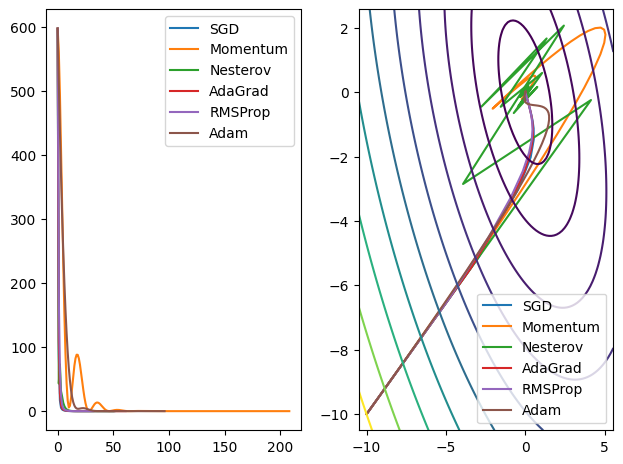

In [15]:
n = 2
lr = 0.1
x = np.array([-10] * n)
bs = 2
f = gen_f(n, 3 + np.random.rand())

fig, axs = plt.subplots(1, 2)
fig.tight_layout()
ax1, ax2 = axs

inf = float('inf')
lm, rm, tm, bm = inf, -inf, -inf, inf

points = best_gradient_descent(f, x, bs)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("SGD:", len(points))

points = best_momentum_gd(f, x, bs)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("Momentum:", len(points))

points = best_nesterov_gd(f, x, bs)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("Nesterov:", len(points))

points = best_adagrad(f, x, bs)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("AdaGrad:", len(points))

points = best_rmsprop(f, x, bs)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("RMSProp:", len(points))

points = best_adam(f, x, bs)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("Adam:", len(points))

lm -= 0.5
rm += 0.5
tm += 0.5
bm -= 0.5

print(lm, rm, tm, bm)

X, Y = np.meshgrid(np.linspace(lm, rm, 100), np.linspace(bm, tm, 100))
ax2.contour(X, Y, f([X, Y]), levels=sorted([f(np.array([p, p])) for p in range(
    1, math.ceil(max(abs(lm), abs(rm), abs(tm), abs(bm))))]))

ax1.legend(['SGD', 'Momentum', 'Nesterov', 'AdaGrad', 'RMSProp', 'Adam'])
ax2.legend(['SGD', 'Momentum', 'Nesterov', 'AdaGrad', 'RMSProp', 'Adam'])


# Bonus task

## Polynomial regression

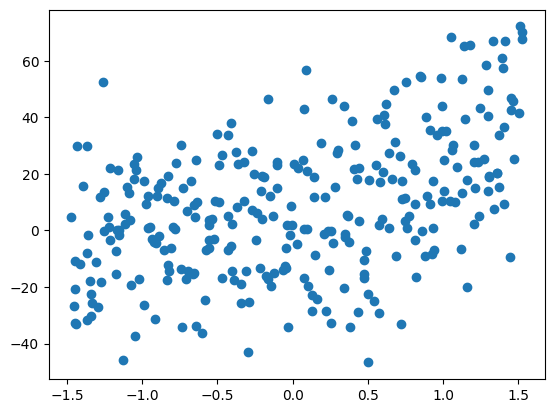

In [16]:
def gen_points(p, count, disp):
    poly = [(-0.5 + float(np.random.rand())) * 20 for i in range(p + 1)]

    def calc(x): return sum(poly[i] * x **
                            i for i in range(p + 1)) + np.random.normal(scale=disp)

    return np.array(sorted([(x := 0.05 * np.random.rand() + (i - count / 2) / (count / 3), calc(x)) for i in range(count)], key=lambda x: x[0]))

def gen_points_with_source(p, count, disp):
    poly = [(-0.5 + float(np.random.rand())) * 20 for i in range(p + 1)]

    def calc(x): return sum(poly[i] * x **
                            i for i in range(p + 1)) + np.random.normal(scale=disp)

    return np.array(sorted([(x := 0.05 * np.random.rand() + (i - count / 2) / (count / 3), calc(x)) for i in range(count)], key=lambda x: x[0])), poly


g = gen_points(3, 300, 20)
plt.scatter(g[:, 0], g[:, 1])


In [17]:
def poly_regression(p, points):
    A = np.array([[x ** i for i in range(p + 1)] for x in points[:, 0]])
    y = points[:, 1]

    t1 = np.linalg.inv(A.T @ A)
    t2 = A.T @ y
    w = t1 @ t2
    y1 = A @ w
    r = y - y1
    err = r.T @ r

    return w, err


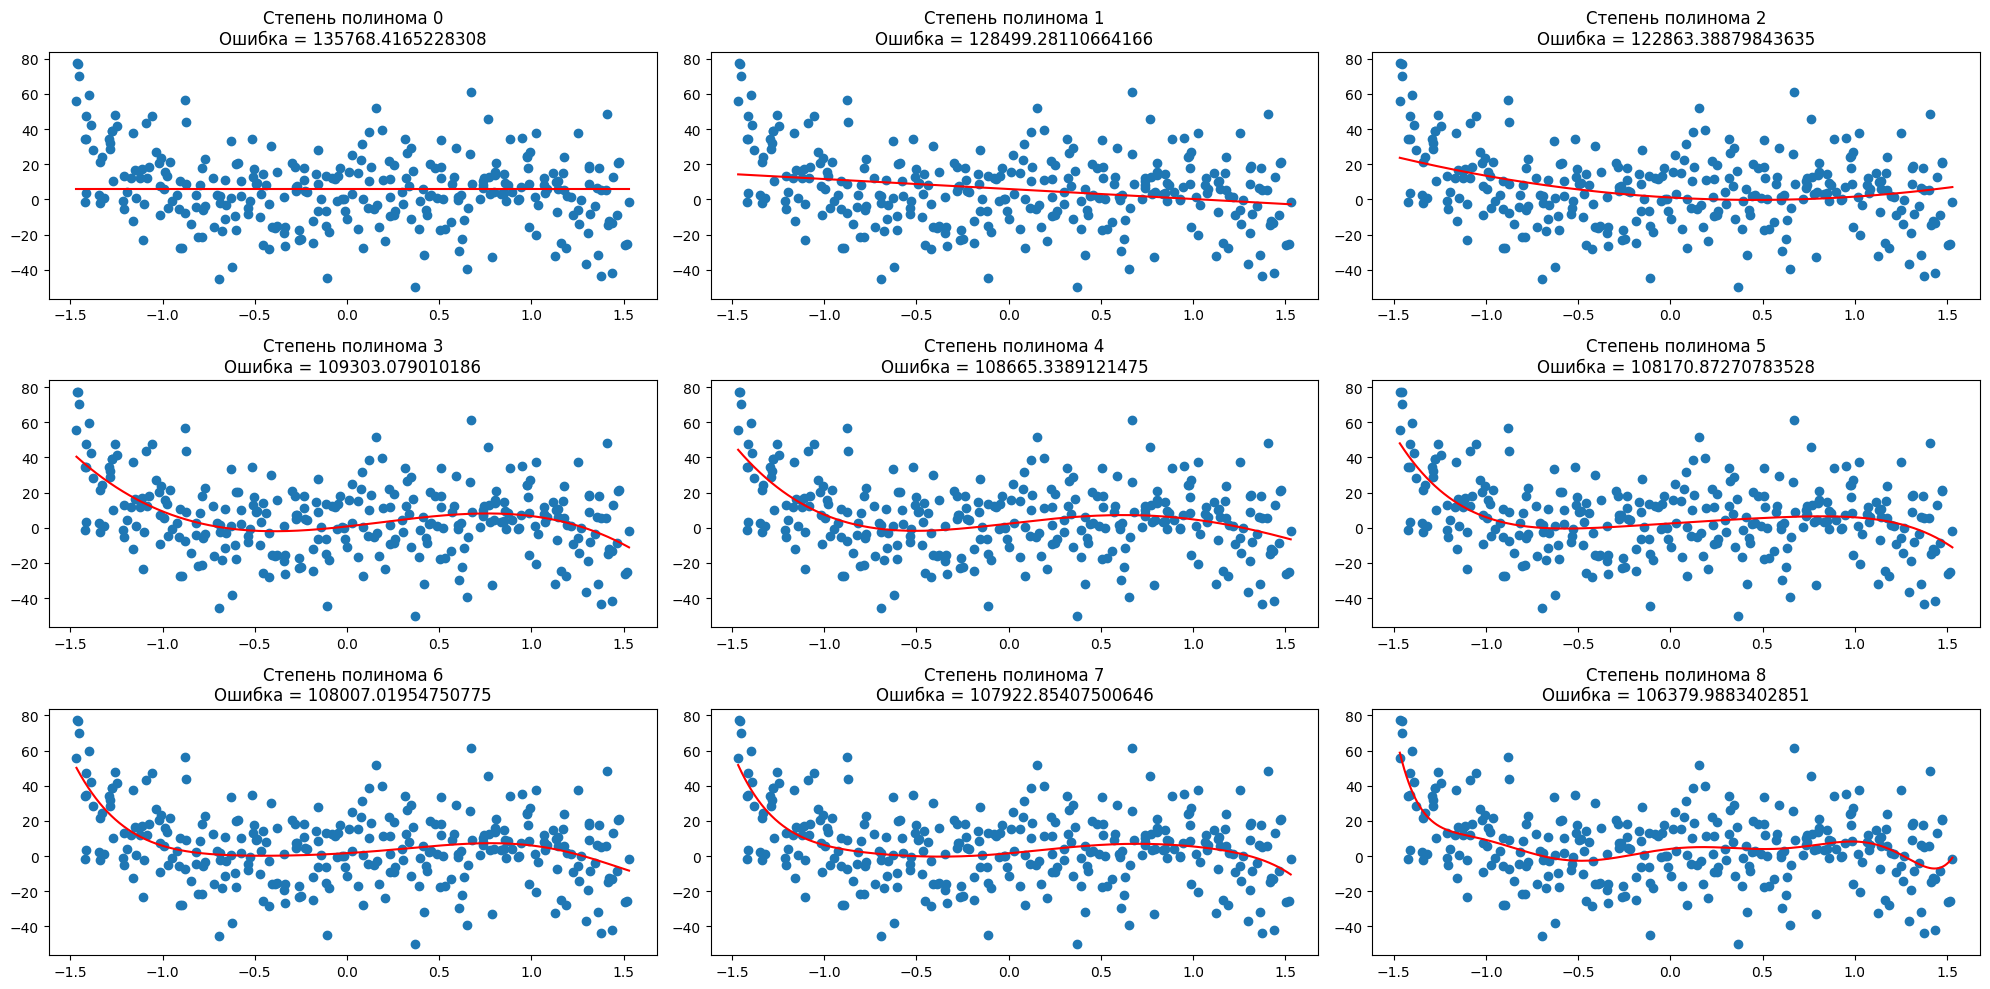

In [18]:
def plot_regr(points, p, ax):
    poly, err = poly_regression(p, points)
    ax.set_title(f'Степень полинома {p}\nОшибка = {err}')

    def y(x): return sum(x ** i * poly[i] for i in range(p + 1))

    X = np.linspace(min(points[:, 0]), max(points[:, 0]), 1000)
    ax.plot(X, y(X), 'r')
    ax.scatter(points[:, 0], points[:, 1])

points = gen_points(5, 300, 20)
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for ax, p in zip(axs.flatten(), range(9)):
    plot_regr(points, p, ax)
fig.tight_layout()


## Regularization

In [19]:

def elastic_regression(p, ps, alpha=0.5, lda=1):
    def rmsprop_loss_f(x, bs, lr, beta, lim=500, eps_mode=False):
        def loss_diff(x, i):
            return 2 / len(ps) * sum((sum(ps[k][0] ** j * x[j] for j in range(p + 1)) - ps[k][1]) * ps[k][0] ** i for k in range(len(ps))) + lda * (alpha + (1 - alpha) * x[i])

        def grad(x):
            indexes = rand_indexes(p + 1, bs)
            g = np.array([0.0] * (p + 1))
            for i in indexes:
                g[i] += loss_diff(x, i)
            return g

        ee = 1e-6
        n = len(x)
        points = []
        points.append(x)
        s = 0
        if eps_mode:
            while True:
                g = grad(x)
                s = s * beta + (1 - beta) * np.dot(g, g)
                delta = - lr * g / np.sqrt(s + ee)
                x = x + delta

                points.append(x)

                if len(points) > lim:
                    return np.array(points)
        else:
            for _ in range(lim):
                g = grad(x)
                s = s * beta + (1 - beta) * np.dot(g, g)
                delta = - lr * g / np.sqrt(s + ee)
                x = x + delta
                points.append(x)

        return np.array(points)

    x = np.array([0.0] * (p + 1))
    return rmsprop_loss_f(x, 1, 1.0, 0.99, lim=500)[-1], None


def l1_regression(p, points, lda=1):
    return elastic_regression(p, points, 0, lda)


def l2_regression(p, points, lda=1):
    return elastic_regression(p, points, 1, lda)


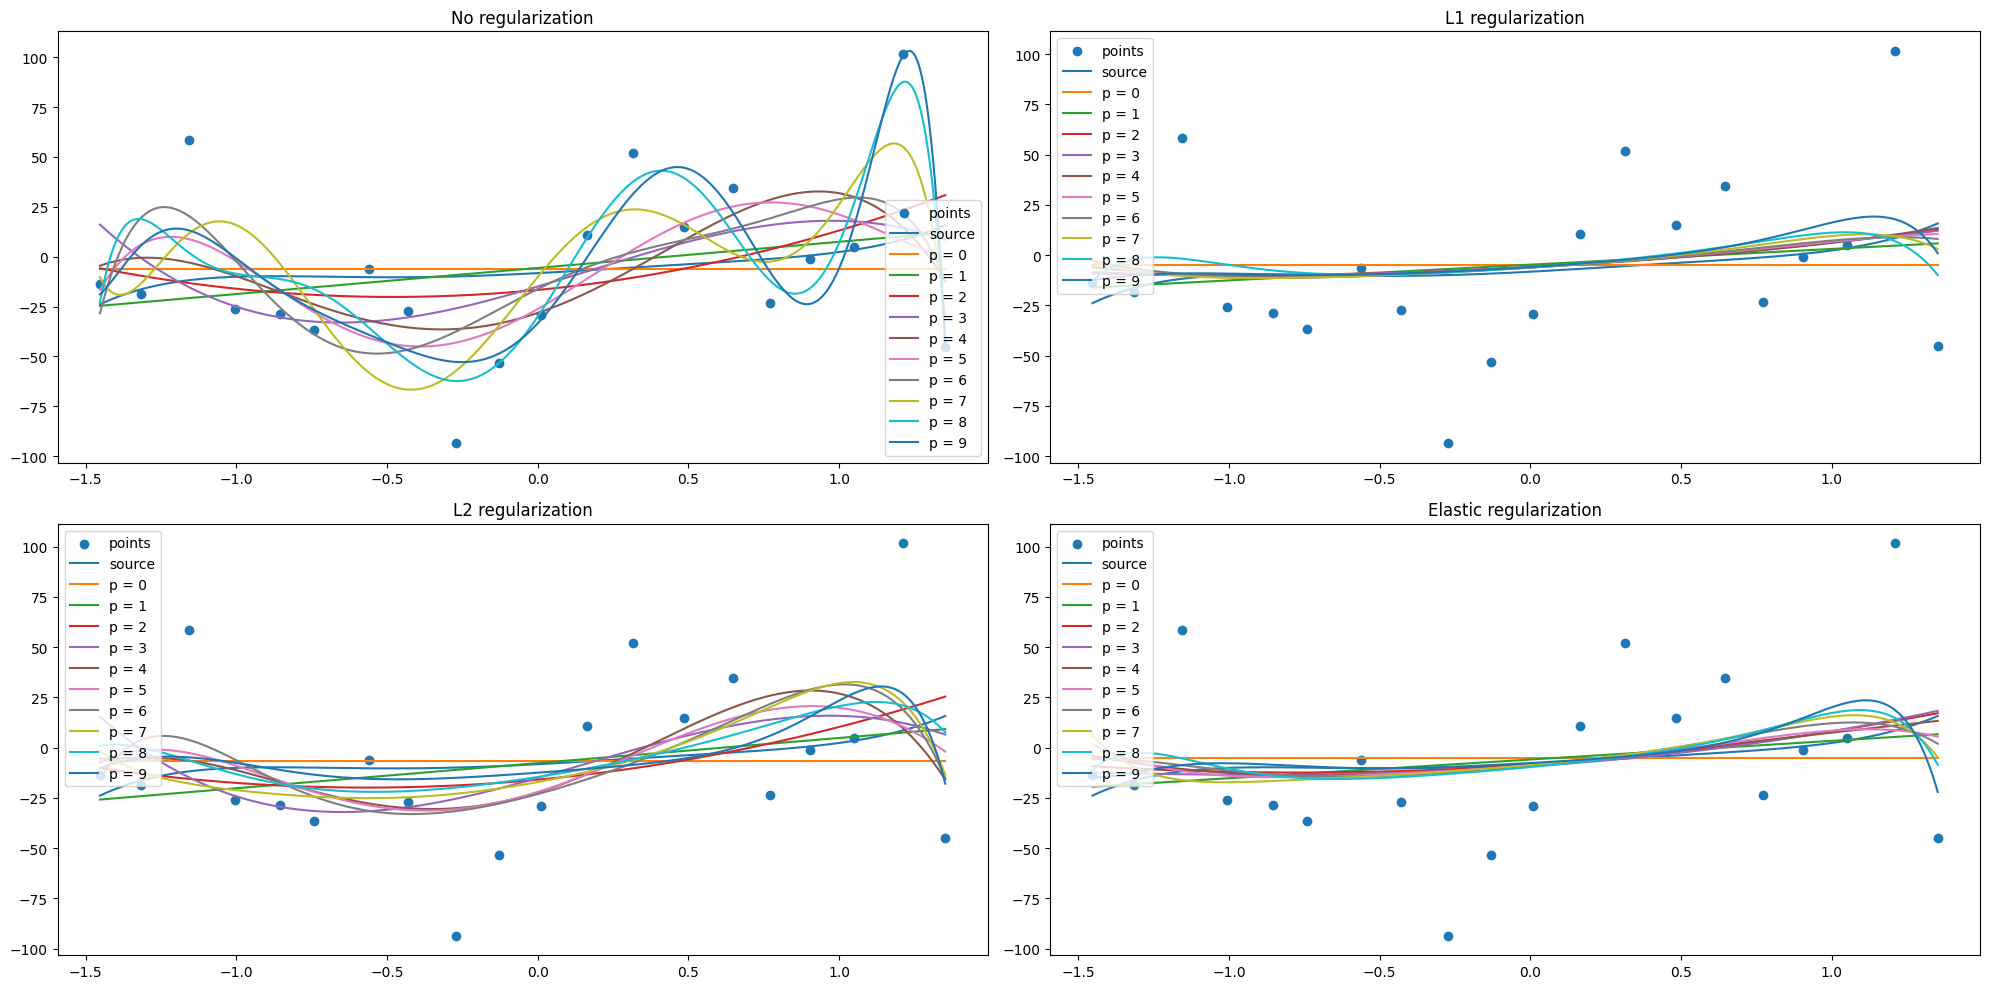

In [20]:
def plot_regr(points, source, p, ax, reg, regname):
    ax.set_title(f'{regname}')

    ax.scatter(points[:, 0], points[:, 1])
    def src(x): 
        return sum(x ** i * source[i] for i in range(p + 1))
    src = np.vectorize(src)
    X = np.linspace(min(points[:, 0]), max(points[:, 0]), 1000)
    ax.plot(X, src(X))
    
    ps = 10
    for p in range(ps):
        poly, err = reg(p, points)
        def y(x): return sum(x ** i * poly[i] for i in range(p + 1))

        X = np.linspace(min(points[:, 0]), max(points[:, 0]), 1000)
        ax.plot(X, y(X))

    ax.legend(['points', 'source'] + [f'p = {i}' for i in range(ps)])


points, source = gen_points_with_source(5, 20, 50)
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
for ax, reg, regname in zip(axs.flatten(),
                               [poly_regression, l1_regression,
                                   l2_regression, elastic_regression],
                               ["No regularization", "L1 regularization", "L2 regularization", "Elastic regularization"]):
    plot_regr(points, source, 5, ax, reg, regname)
fig.tight_layout()
